<a href="https://colab.research.google.com/github/kabirodavies/ML_classification/blob/main/Climate_Change_Belief_Analysis_Final1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Overview

Many companies are built around lessening one’s environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.

With this context, EDSA is challenging you during the Classification Sprint with the task of creating a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

Providing an accurate and robust solution to this task gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies.


The structure of this notebook is as follows:


<a id="cont"></a>

## Table of Contents

<a href=#one>1. Importing Packages</a>

<a href=#two>2. The Dataset</a>

<a href=#three>3. Text Pre-processing & Data Cleaning</a>

<a href=#three>4. Exploratory Data Analysis (EDA)</a>

<a href=#four>5. Dealing with Imbalanced Data</a>

<a href=#five>6. Feature Extraction</a>

<a href=#five>7. Modeling</a>

<a href=#seven>8. File Submission</a>



 <a id="one"></a>
## 1.0 Importing Packages
<a href=#cont>Back to Table of Contents</a>

---
    
 Description: Importing Packages 


In [1]:
%matplotlib inline
## for data
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from collections import  Counter
## for processing
import re
import nltk
from nltk.corpus import stopwords

# for bag-of-words
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
# for word embedding
import gensim
import gensim.downloader as gensim_api

#Data Imbalance
from sklearn.utils import resample

#Feature Eng
from tqdm import tqdm 
tqdm.pandas(desc="progress-bar") 
from gensim.models.doc2vec import LabeledSentence

#Encoding
from sklearn.preprocessing import LabelEncoder

#Algorithms
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB

#Grid Search
from sklearn.model_selection import GridSearchCV

#Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

# Warnings
import warnings 

pd.set_option("display.max_colwidth", 200) 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

warnings.filterwarnings('ignore')

In [2]:
url_train = 'https://raw.githubusercontent.com/kabirodavies/ML_classification/main/train.csv'
url_test = 'https://raw.githubusercontent.com/kabirodavies/ML_classification/main/test.csv'
url_sub = 'https://raw.githubusercontent.com/kabirodavies/ML_classification/main/sample_submission.csv'


 <a id="one"></a>
## 2.0 The Dataset
<a href=#cont>Back to Table of Contents</a>

---
    
 Description: Bried overview of the data.


Data The collection of this data was funded by a Canada Foundation for Innovation JELF Grant to Chris Bauch, University of Waterloo. The dataset aggregates tweets pertaining to climate change collected between Apr 27, 2015 and Feb 21, 2018. In total, 43943 tweets were collected. Each tweet is labelled as one of the following classes:

##Class Description:
 

* 2 News: the tweet links to factual news about climate change
* 1 Pro: the tweet supports the belief of man-made climate change
* 0 Neutral: the tweet neither supports nor refutes the belief of man-made climate change
* -1 Anti: the tweet does not believe in man-made climate change

##Columns:

*   sentiment: Sentiment of tweet i.e 0, 1, etc
*   message: Tweet body
*   tweetid: Twitter unique id








### Read the data

In [3]:
#Read the data
train = pd.read_csv(url_train)
train.head()

,sentiment,message,tweetid
0,1,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable",625221
1,1,It's not like we lack evidence of anthropogenic global warming,126103
2,2,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight",466954


In [4]:
test = pd.read_csv(url_test)
test.head()

,message,tweetid
0,Europe will now be looking to China to make sure that it is not alone in fighting climate change… https://t.co/O7T8rCgwDq,169760
1,Combine this with the polling of staffers re climate change and womens' rights and you have a fascist state. https://t.co/ifrm7eexpj,35326
2,"The scary, unimpeachable evidence that climate change is already here: https://t.co/yAedqcV9Ki #itstimetochange #climatechange @ZEROCO2_;..",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPutin got to you too Jill ! \nTrump doesn't believe in climate change at all \nThinks it's s hoax,476263
4,RT @FakeWillMoore: 'Female orgasms cause global warming!'\n-Sarcastic Republican,872928


In [5]:
train.shape, test.shape

((15819, 3), (10546, 2))

In [6]:
train.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10546 entries, 0 to 10545
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  10546 non-null  object
 1   tweetid  10546 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 164.9+ KB


### To ease text cleaning, we're going to combine train and test data

In [8]:
combi = train.append(test, ignore_index=True, sort=True)
combi.shape

(26365, 3)

<a id="one"></a>
## 3.0 Text Pre-processing & Data Cleaning
<a href=#cont>Back to Table of Contents</a>

---
    
 Description: Real world data is messy. This step is all about removing the noice from data. With the use of regualr expressions we can remove unwanted charecters which include: Emojis, digits, RT for retweets, Hashtags, symbols like @, !, $, &, urls.

Text preprocessing is a method to clean the text data and make it ready to feed data to the model.




###Expand Contractions

In [9]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

In [10]:
# Regular expression for finding contractions
contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

In [11]:
# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

In [12]:
# Expanding Contractions in the reviews
combi['message_contract']=combi['message'].apply(lambda x:expand_contractions(x))

In [13]:
#Removing Short Words
combi["clean_message"] = combi.message_contract.apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))
combi.head(10)

,message,sentiment,tweetid,message_contract,clean_message
0,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable",1.0,625221,"PolySciMajor EPA chief does not think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable","PolySciMajor EPA chief does not think carbon dioxide main cause global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable"
1,It's not like we lack evidence of anthropogenic global warming,1.0,126103,It is not like we lack evidence of anthropogenic global warming,not like lack evidence anthropogenic global warming
2,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…,2.0,698562,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…,@RawStory: Researchers say have three years act climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…
3,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,1.0,573736,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,#TodayinMaker# WIRED 2016 was pivotal year the war climate change https://t.co/44wOTxTLcD
4,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight",1.0,466954,"RT @SoyNovioDeTodas: It is 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight","@SoyNovioDeTodas: 2016, and racist, sexist, climate change denying bigot leading the polls. #ElectionNight"
5,Worth a read whether you do or don't believe in climate change https://t.co/ggLZVNYjun https://t.co/7AFE2mAH8j,1.0,425577,Worth a read whether you do or do not believe in climate change https://t.co/ggLZVNYjun https://t.co/7AFE2mAH8j,Worth read whether you not believe climate change https://t.co/ggLZVNYjun https://t.co/7AFE2mAH8j
6,RT @thenation: Mike Pence doesn’t believe in global warming or that smoking causes lung cancer. https://t.co/gvWYaauU8R,1.0,294933,RT @thenation: Mike Pence doesn’t believe in global warming or that smoking causes lung cancer. https://t.co/gvWYaauU8R,@thenation: Mike Pence doesn’t believe global warming that smoking causes lung cancer. https://t.co/gvWYaauU8R
7,"RT @makeandmendlife: Six big things we can ALL do today to fight climate change, or how to be a climate activistÃ¢â‚¬Â¦ https://t.co/TYMLu6DbNM hÃ¢â‚¬Â¦",1.0,992717,"RT @makeandmendlife: Six big things we can ALL do today to fight climate change, or how to be a climate activistÃ¢â‚¬Â¦ https://t.co/TYMLu6DbNM hÃ¢â‚¬Â¦","@makeandmendlife: Six big things can ALL today fight climate change, how climate activistÃ¢â‚¬Â¦ https://t.co/TYMLu6DbNM hÃ¢â‚¬Â¦"
8,"@AceofSpadesHQ My 8yo nephew is inconsolable. He wants to die of old age like me, but will perish in the fiery hellscape of climate change.",1.0,664510,"@AceofSpadesHQ My 8yo nephew is inconsolable. He wants to die of old age like me, but will perish in the fiery hellscape of climate change.","@AceofSpadesHQ 8yo nephew inconsolable. wants die old age like me, but will perish the fiery hellscape climate change."
9,RT @paigetweedy: no offense… but like… how do you just not believe… in global warming………,1.0,260471,RT @paigetweedy: no offense… but like… how do you just not believe… in global warming………,@paigetweedy: offense… but like… how you just not believe… global warming………


In [14]:
nltk.download(['punkt','stopwords', 'wordnet'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
lst_stopwords = nltk.corpus.stopwords.words("english")

def utils_preprocess_text(message, flg_stemm=False, flg_lemm=True, lst_stopwords='english'):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(message).lower().strip())
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # Remove @mentions
    text = re.sub(r'#', '', text) # Remove '#' symbol
    text = re.sub(r':', '', text) # Remove ':' symbol
    text = re.sub(r'rt[\s]+', '', text) #Remove RT
    text = re.sub(r'https?:\/\/\S+', '', text) # Remove hyperlink
    text = re.sub(r'\w*\d\w*', '', text) # Remove numbers
    text = re.sub('http\S+|www.\S+', '', text)
    text = re.sub(r'[^A-Za-z ]', '', text)
    text = re.sub(r'‘[A-Z][^A-Z]*’', '', text)
    
    text = re.sub(r'\w*\d\w*','', text) # Remove digits and words containing digits
    text = re.sub(r' +',' ', text) #Revove extra spaces
    

    text = re.sub('[.?]', '', text)
    text = re.sub('https?://\S+|www.\S+', '', text)
    text = re.sub('<.?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w\d\w', '', text)
    

              
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [16]:
combi["clean_message"] = combi["message_contract"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))

combi.head()

,message,sentiment,tweetid,message_contract,clean_message
0,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable",1.0,625221,"PolySciMajor EPA chief does not think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable",polyscimajor epa chief think carbon dioxide main cause global warming wait via mashable
1,It's not like we lack evidence of anthropogenic global warming,1.0,126103,It is not like we lack evidence of anthropogenic global warming,like lack evidence anthropogenic global warming
2,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…,2.0,698562,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…,rawstory researcher say three year act climate change late
3,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,1.0,573736,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,todayinmaker wired pivotal year war climate change
4,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight",1.0,466954,"RT @SoyNovioDeTodas: It is 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight",soynoviodetodas racist sexist climate change denying bigot leading poll electionnight


<a id="one"></a>
## 4.0 Exploratory Data Analysis(EDA)
<a href=#cont>Back to Table of Contents</a>

---

 Description:
1.   Visual representation of most used words in the 4 classes of tweets.
2.   Plot frequency of hashtags by sentiment.
3.   Plot frequency of words by sentiment.

In [17]:
# Separating dataframes
train_df = combi.iloc[:15819,:]
test_df = combi.iloc[15819:,:]

In [18]:
#Distribution of the Sentiment Column
train_df['sentiment'].value_counts()

 1.0    8530
 2.0    3640
 0.0    2353
-1.0    1296
Name: sentiment, dtype: int64

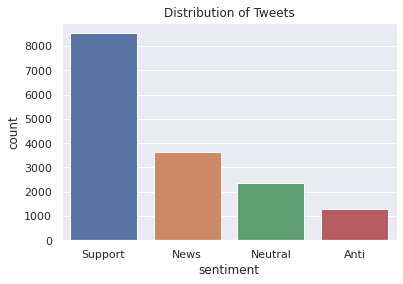

In [19]:
#Distribution of tweets
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="sentiment", data=train_df,
                order=train_df['sentiment'].value_counts().index)
ax.set(xticklabels = (['Support', 'News', 'Neutral', 'Anti']))
plt.title('Distribution of Tweets')
None #don't show the label objects

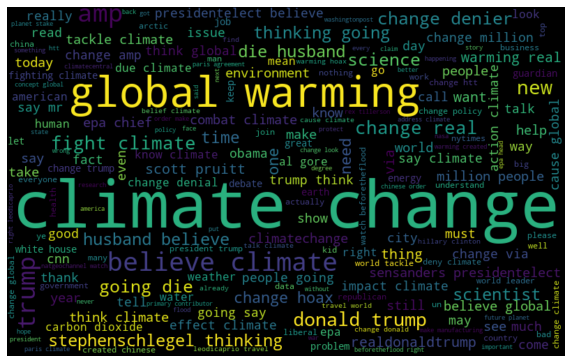

In [20]:
#Most common words in the train data
all_words = ' '.join([text for text in train_df['clean_message']]) 

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.show()

###Visual representation of most used words in the four classes of tweets

####a. support sentiment

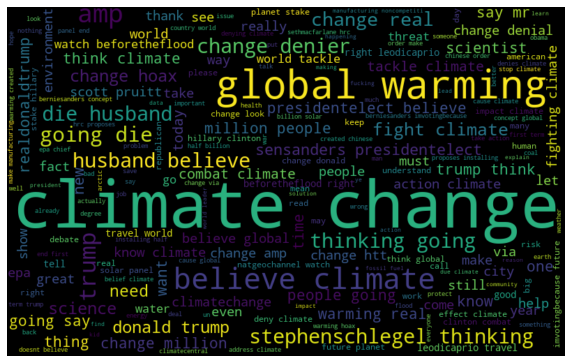

In [21]:
#Most common words in the train data from support sentiment
all_words = ' '.join([text for text in train_df['clean_message'][train_df['sentiment']==1]]) 

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.show()

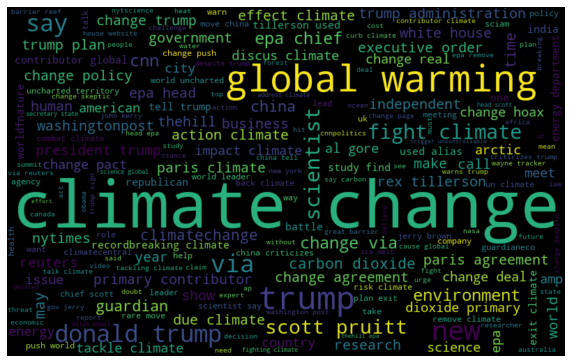

In [22]:
#Most common news words
all_words = ' '.join([text for text in train_df['clean_message'][train_df['sentiment']==2]]) 

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.show()

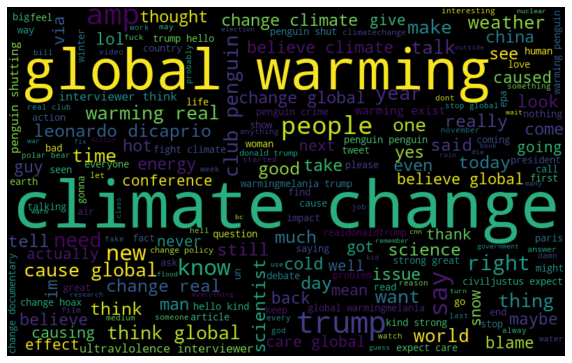

In [23]:
#Most common neutral words
all_words = ' '.join([text for text in train_df['clean_message'][train_df['sentiment']==0]]) 

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.show()

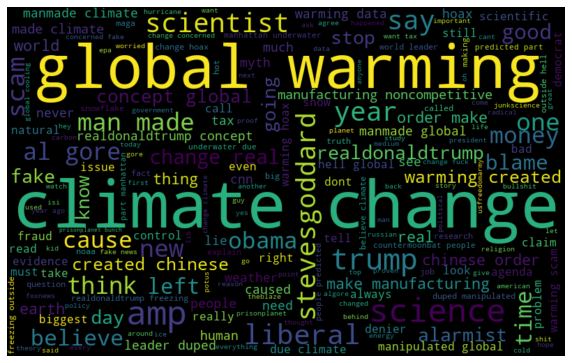

In [24]:
#Most common anti climate change words
all_words = ' '.join([text for text in train_df['clean_message'][train_df['sentiment']==-1]]) 

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.show()

###Plot frequency of hashtags by sentiment.

In [25]:
#Extract Hashtag
def hashtag_extract(tweets):
  hashtags = []
  for tweet in tweets:
    ht = re.findall(r'#(\w+)', tweet)
    hashtags.append(ht)
  return hashtags


In [26]:
#Extract hashtags from anti climate change tweets
ht_negative = hashtag_extract(train_df['message'][train_df['sentiment']==-1])

#Extract hashtags from neutral climate change tweets
ht_neutral = hashtag_extract(train_df['message'][train_df['sentiment']==0])

#Extract hashtags from positive climate change tweets
ht_positive = hashtag_extract(train_df['message'][train_df['sentiment']==1])

#Extract hashtags from news climate change tweets
ht_news = hashtag_extract(train_df['message'][train_df['sentiment']==2])

In [27]:
ht_positive = sum(ht_positive,[])
ht_negative = sum(ht_negative, [])
ht_neutral = sum(ht_neutral, [])
ht_news = sum(ht_news, [])

In [28]:
ht_positive[:10]

['TodayinMaker',
 'ElectionNight',
 'climatemarch',
 'SaveOurPlanet',
 'COP22',
 'EarthToMarrakech',
 'climateÃ',
 'ObamaUNC',
 'cdnpoli',
 'JohnHoldren']

In [29]:
freq = nltk.FreqDist(ht_positive)
d = pd.DataFrame({'Hashtag': list(freq.keys()),
                 'Count': list(freq.values())})
d.head()

,Hashtag,Count
0,TodayinMaker,1
1,ElectionNight,8
2,climatemarch,6
3,SaveOurPlanet,1
4,COP22,59


In [30]:
#Dict from NLTK to process Hashtags
freq_positive = nltk.FreqDist(ht_positive)
freq_negative = nltk.FreqDist(ht_negative)
freq_news = nltk.FreqDist(ht_news)
freq_neutral = nltk.FreqDist(ht_neutral)

#Dataframe for Positive Hashtags
positive_tags = pd.DataFrame({'Hashtag': list(freq_positive.keys()),
                 'Count': list(freq_positive.values())})

#Dataframe for Negative Hashtags
negative_tags = pd.DataFrame({'Hashtag': list(freq_negative.keys()),
                 'Count': list(freq_negative.values())})

#Dataframe for News Hashtags
news_tags = pd.DataFrame({'Hashtag': list(freq_news.keys()),
                 'Count': list(freq_news.values())})

#Dataframe for Neutral Hashtags
neutral_tags = pd.DataFrame({'Hashtag': list(freq_neutral.keys()),
                 'Count': list(freq_neutral.values())})

In [31]:
positive_tags

,Hashtag,Count
0,TodayinMaker,1
1,ElectionNight,8
2,climatemarch,6
3,SaveOurPlanet,1
4,COP22,59
...,...,...
1250,Turkey,1
1251,Geeky0001,1
1252,LeoDiCaprio,1
1253,FL26,1


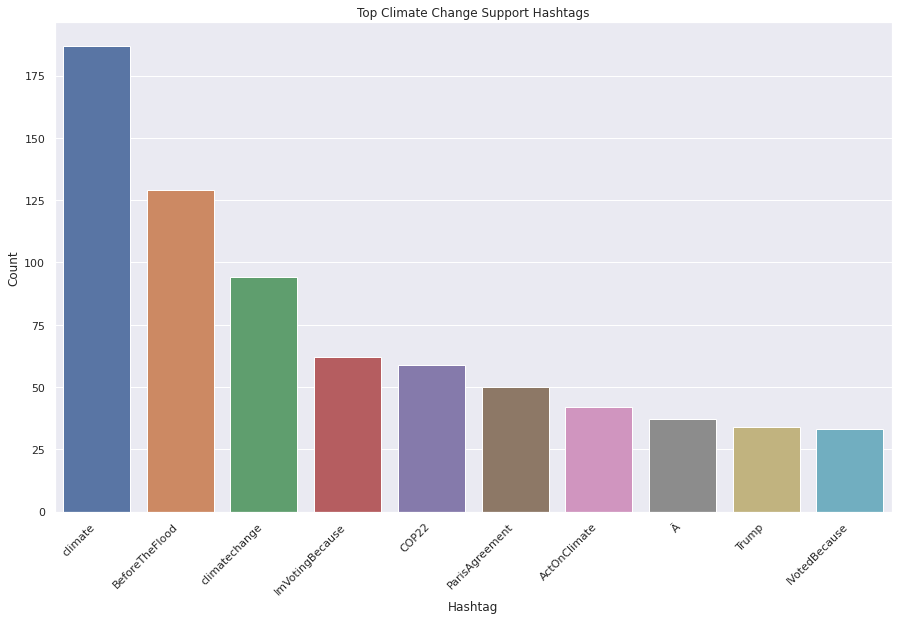

In [32]:
# select top 10 positive hashtags
positive_tags = positive_tags.nlargest(columns='Count', n=10)
plt.figure(figsize=(15,9))
chart = sns.barplot(
    data=positive_tags,
    x='Hashtag', y='Count'
)
plt.title('Top Climate Change Support Hashtags')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

None #don't show the label objects

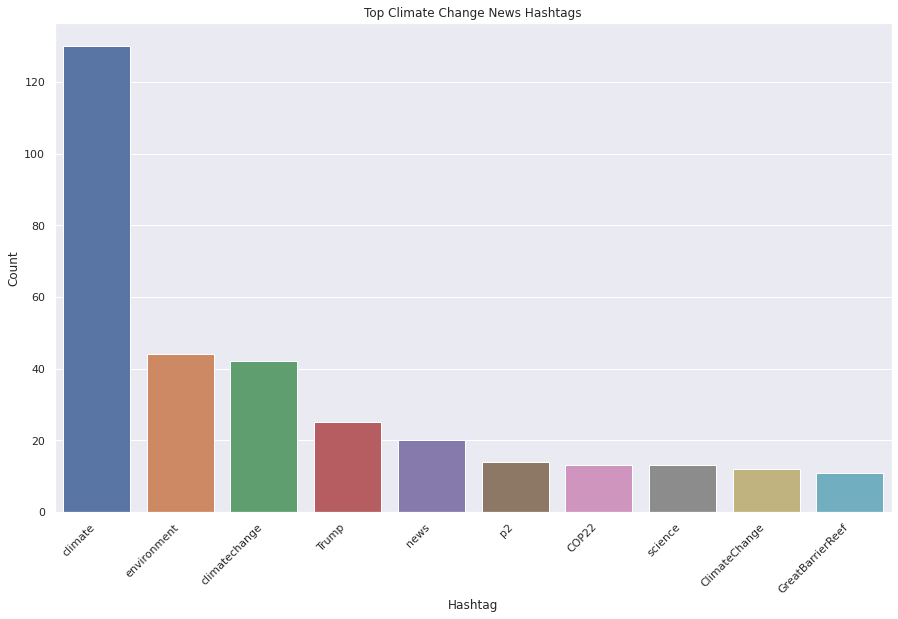

In [33]:
# select top 10 news hashtags
news_tags = news_tags.nlargest(columns='Count', n=10)
plt.figure(figsize=(15,9))
chart = sns.barplot(
    data=news_tags,
    x='Hashtag', y='Count'
)
plt.title('Top Climate Change News Hashtags')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

None #don't show the label objects

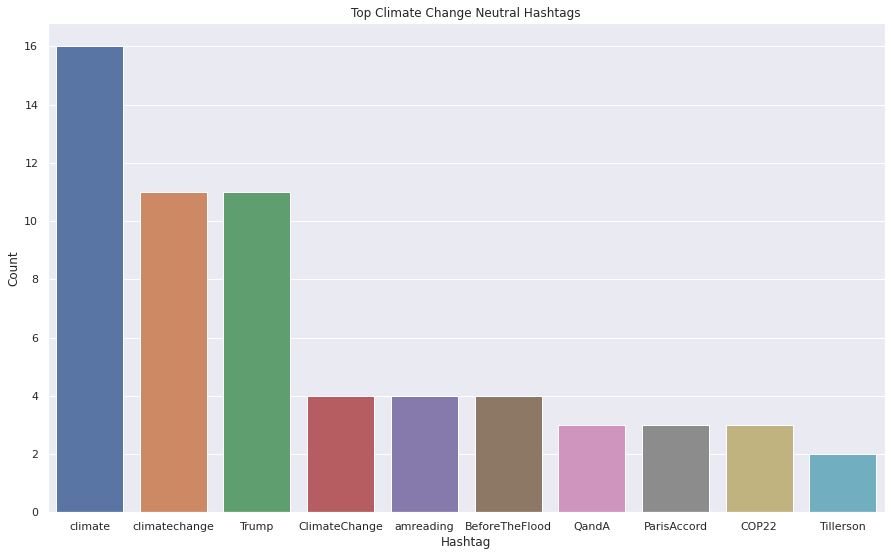

In [34]:
# select top 10 neutral hashtags
neutral_tags = neutral_tags.nlargest(columns='Count', n=10)
plt.figure(figsize=(15,9))
sns.barplot(data=neutral_tags, x='Hashtag', y='Count')
plt.title('Top Climate Change Neutral Hashtags')
plt.show()

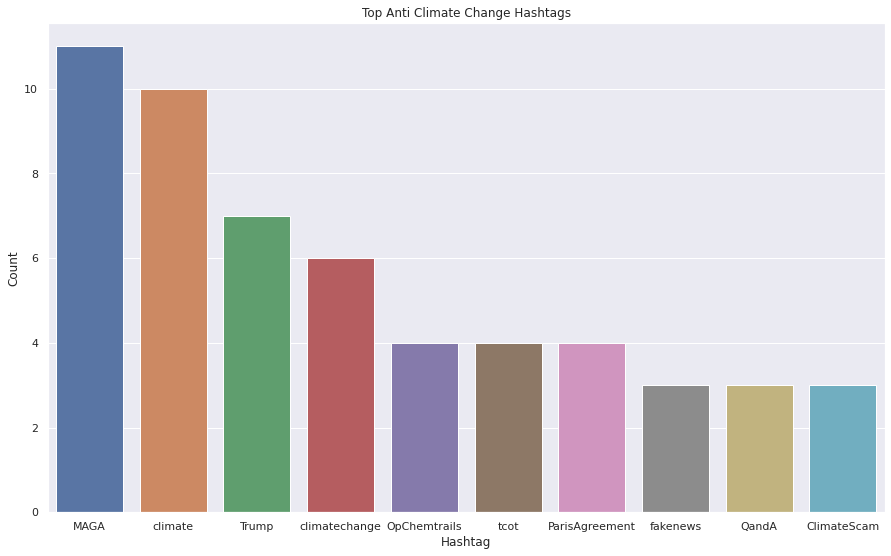

In [35]:
# select top 10 anti climate change hashtags
negative_tags = negative_tags.nlargest(columns='Count', n=10)
plt.figure(figsize=(15,9))
sns.barplot(data=negative_tags, x='Hashtag', y='Count')
plt.title('Top Anti Climate Change Hashtags')

plt.show()

##Frequency of words by sentiment

In [36]:
train_df['text_n_chars'] = train_df.clean_message.apply(len)  # count all chars in each sentence

In [37]:
train_df['text_n_words'] = train_df.clean_message.apply(lambda sent: len(sent.split()))  # count number of words in each sentence
train_df.head()

,message,sentiment,tweetid,message_contract,clean_message,text_n_chars,text_n_words
0,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable",1.0,625221,"PolySciMajor EPA chief does not think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable",polyscimajor epa chief think carbon dioxide main cause global warming wait via mashable,87,13
1,It's not like we lack evidence of anthropogenic global warming,1.0,126103,It is not like we lack evidence of anthropogenic global warming,like lack evidence anthropogenic global warming,47,6
2,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…,2.0,698562,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…,rawstory researcher say three year act climate change late,58,9
3,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,1.0,573736,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,todayinmaker wired pivotal year war climate change,50,7
4,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight",1.0,466954,"RT @SoyNovioDeTodas: It is 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight",soynoviodetodas racist sexist climate change denying bigot leading poll electionnight,85,10


In [38]:
train_df['sentiment'].value_counts()

 1.0    8530
 2.0    3640
 0.0    2353
-1.0    1296
Name: sentiment, dtype: int64

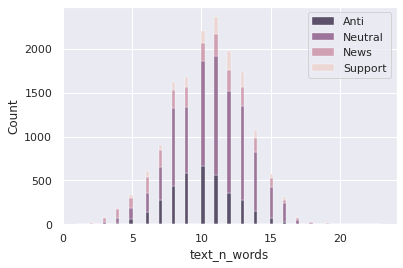

In [39]:
# The distribution of number of words for each sentiment
sns.histplot(data=train_df, x='text_n_words',
             hue='sentiment', multiple='stack', color='seagreen')
plt.legend(labels=['Anti', 'Neutral', 'News', 'Support'])
None #don't show the label objects

In [40]:
# Most frequent words. In whole Text.
words = [word for sent in train_df['clean_message'] for word in sent.split()]
words[:10]  # words without sorting

['polyscimajor',
 'epa',
 'chief',
 'think',
 'carbon',
 'dioxide',
 'main',
 'cause',
 'global',
 'warming']

In [41]:
# sort words descending order
freq_words = Counter(words)
freq_words_sorted = sorted(freq_words.items(), key=lambda pair: pair[1], reverse=True)
freq_words_df = pd.DataFrame(freq_words_sorted[:20], columns=['word', 'counts'])
freq_words_df.head(10)

,word,counts
0,climate,12916
1,change,12512
2,global,3771
3,warming,3456
4,trump,2385
5,believe,1158
6,u,1042
7,amp,878
8,say,793
9,world,729


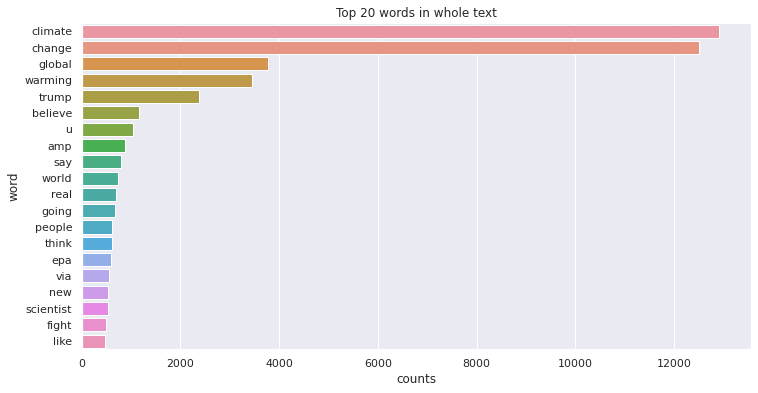

In [42]:
plt.figure(figsize=(12, 6))
sns.barplot(data=freq_words_df, x='counts', y='word')
plt.title('Top 20 words in whole text')
plt.show()

##Frequent words for each sentiment

In [43]:
# Frequent words for each sentiment
def freq_sentiment_words(text, sentiment, num):
    '''
        take the whole data, and return data which is have # of words in each sentiment has been passed
    '''
    words = [word for sent in text[text['sentiment'] == sentiment]
             ['clean_message'] for word in sent.split()]
    freq_words = Counter(words)
    freq_words_sorted = sorted(
        freq_words.items(), key=lambda pair: pair[1], reverse=True)
    freq_words_df = pd.DataFrame(
        freq_words_sorted[:num], columns=['word', 'counts'])
    return freq_words_df


In [44]:
def plot_freq(data, st):
    '''
        take the data, and st refeere to kind of sentiment
    '''
    plt.figure(figsize=(12, 6))
    sns.barplot(data=data, x='counts', y='word')
    plt.title(f'Top 20 words in {st} sentiment')
    plt.show()

      word  counts
0  climate    7340
1   change    7126
2   global    1593
3  warming    1439
4    trump    1084


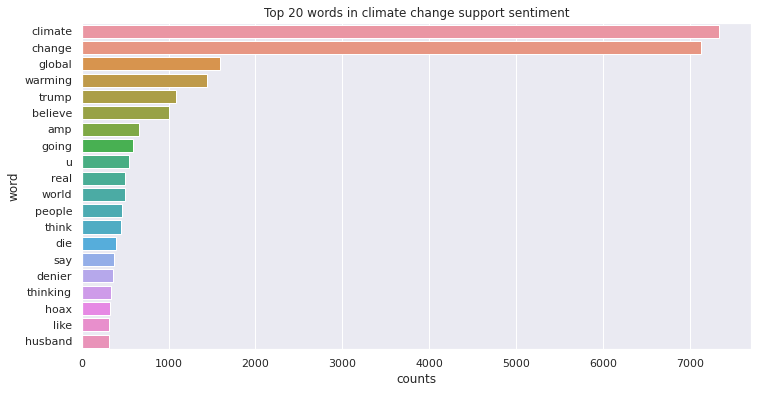

In [45]:
# In Positive Sentiment
positive_words = freq_sentiment_words(train_df, 1, 20)
print(positive_words.head())
plot_freq(positive_words, 'climate change support')

      word  counts
0  climate    3346
1   change    3258
2    trump    1064
3   global     507
4  warming     442


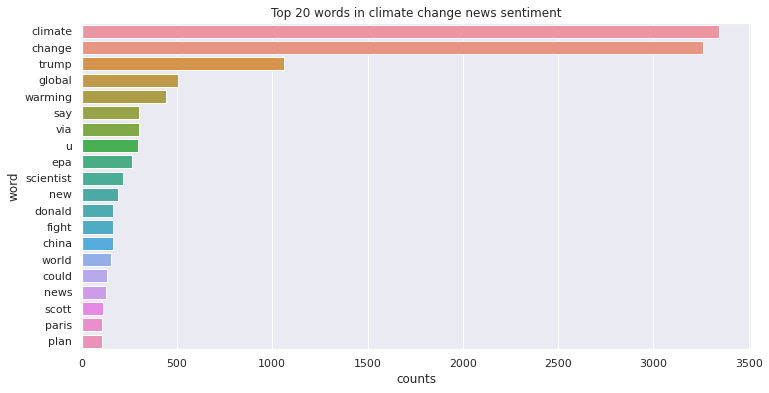

In [46]:
# In News Sentiment
positive_words = freq_sentiment_words(train_df, 2, 20)
print(positive_words.head())
plot_freq(positive_words, 'climate change news')

      word  counts
0  climate    1438
1   change    1386
2   global    1037
3  warming     971
4    trump     173


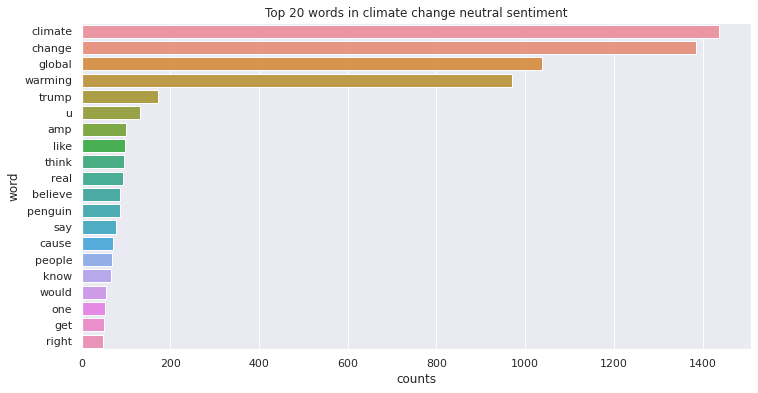

In [47]:
# In Neutral Sentiment
positive_words = freq_sentiment_words(train_df, 0, 20)
print(positive_words.head())
plot_freq(positive_words, 'climate change neutral')

      word  counts
0  climate     792
1   change     742
2   global     634
3  warming     604
4      amp      84


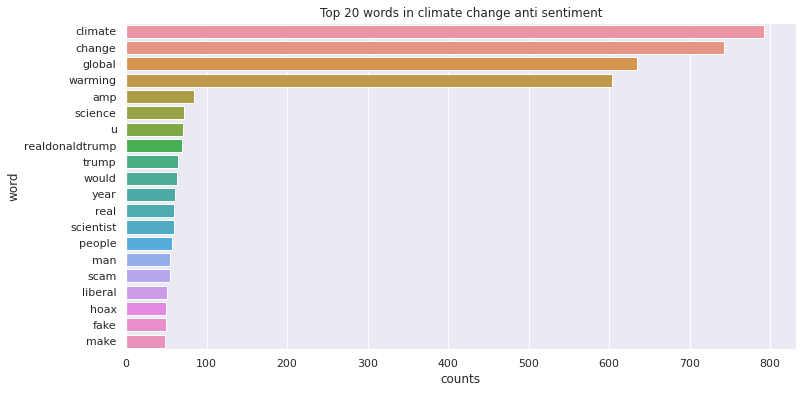

In [48]:
# In Anti Sentiment
positive_words = freq_sentiment_words(train_df, -1, 20)
print(positive_words.head())
plot_freq(positive_words, 'climate change anti')

In [49]:
# getting list of support climate change words
positive_text_clean = train_df[train_df['sentiment'] == 1]['clean_message']
positive_clean_words = [
    word for words in positive_text_clean for word in words.split()]
positive_clean_words[:10]

['polyscimajor',
 'epa',
 'chief',
 'think',
 'carbon',
 'dioxide',
 'main',
 'cause',
 'global',
 'warming']

In [50]:
# getting list of anti climate change words
negative_text_clean = train_df[train_df['sentiment'] == -1]['clean_message']
negative_clean_words = [word for words in negative_text_clean for word in words.split()]
negative_clean_words[:10]

['sally',
 'kohns',
 'latest',
 'evidence',
 'climate',
 'change',
 'prof',
 'smaperson',
 'via',
 'twitchyteam']

In [51]:
# getting list of neutral climate change words
neutral_text_clean = train_df[train_df['sentiment'] == 0]['clean_message']
neutral_clean_words = [word for words in neutral_text_clean for word in words.split()]
neutral_clean_words[:10]

['calum',
 'tweet',
 'abt',
 'reunitingish',
 'w',
 'castsees',
 'reply',
 'begging',
 'come',
 'countriescalum']

In [52]:
# getting list of news-related climate change words
news_text_clean = train_df[train_df['sentiment'] == 2]['clean_message']
news_clean_words = [
    word for words in news_text_clean for word in words.split()]
news_clean_words[:10]

['rawstory',
 'researcher',
 'say',
 'three',
 'year',
 'act',
 'climate',
 'change',
 'late',
 'tveitdal']

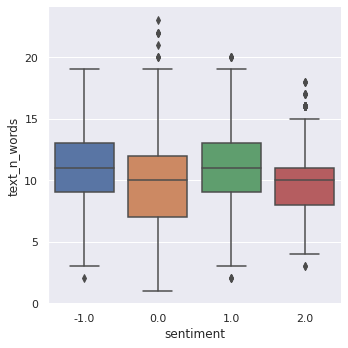

In [53]:
#Distribution of words sentiment
sns.catplot(x="sentiment", y="text_n_words", kind="box", data=train_df)

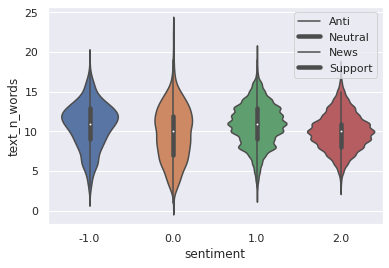

In [54]:
sns.violinplot(x='sentiment', y='text_n_words', data=train_df)
plt.legend(labels=['Anti', 'Neutral', 'News', 'Support'])

### WordCloud 

Text(0.5, 1.0, 'News Text')

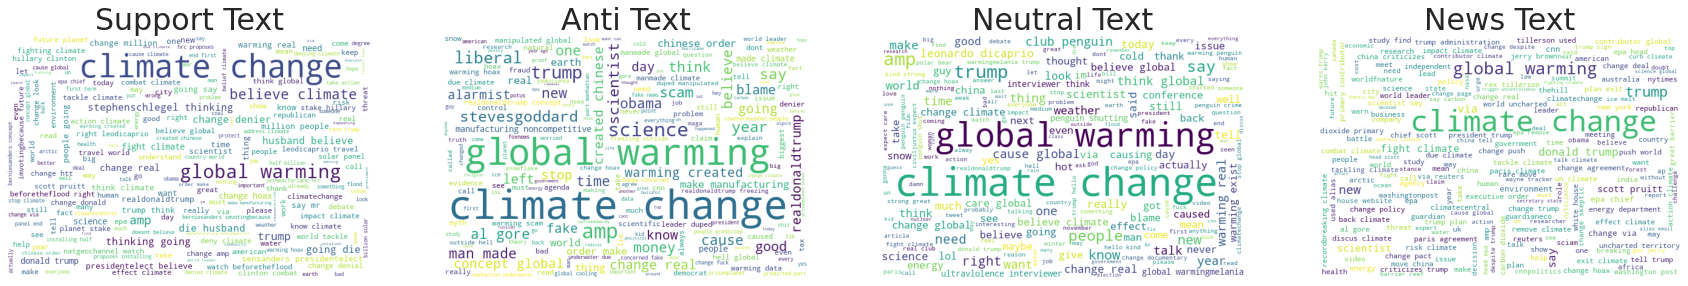

In [55]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=[30, 15])

wordcloud1 = WordCloud(background_color='white',
                       width=600,
                       height=400).generate(" ".join(positive_clean_words))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Support Text', fontsize=30)

wordcloud2 = WordCloud(background_color='white',
                       width=600,
                       height=400).generate(" ".join(negative_clean_words))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Anti Text', fontsize=30)

wordcloud3 = WordCloud(background_color='white',
                       width=600,
                       height=400).generate(" ".join(neutral_clean_words))
ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Neutral Text', fontsize=30)

wordcloud4 = WordCloud(background_color='white',
                       width=600,
                       height=400).generate(" ".join(news_clean_words))
ax4.imshow(wordcloud4)
ax4.axis('off')
ax4.set_title('News Text', fontsize=30)

<a id="one"></a>
## 5.0 Dealing with Imbalanced Data
<a href=#cont>Back to Table of Contents</a>

---
    
 Notes: We discovered upsampling didn't have an impact on the accuracy of our model

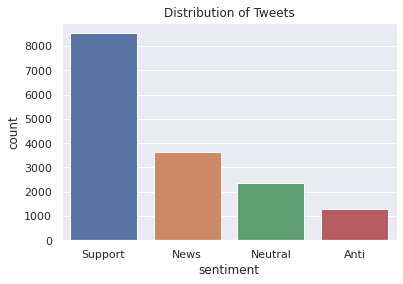

In [59]:
#Distribution of tweets
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="sentiment", data=train_df,
                order=train_df['sentiment'].value_counts().index)
ax.set(xticklabels = (['Support', 'News', 'Neutral', 'Anti']))
plt.title('Distribution of Tweets')
None #don't show the label objects

In [58]:
# Sentiment percentage of data before resampling.
# Separate minority and majority classes
news = train_df[train_df['sentiment']==2]
support = train_df[train_df['sentiment']==1]
neutral = train_df[train_df['sentiment']==0]
anti = train_df[train_df['sentiment']==-1]


print(f' Support: {round(len(support)/(len(train_df))*100, 2)} %')
print(f' News: {round(len(news)/(len(train_df))*100, 2)} %')
print(f' Neutral: {round(len(neutral)/(len(train_df))*100, 2)} %')
print(f' Anti: {round(len(anti)/(len(train_df))*100, 2)} %')

 Support: 53.92 %
 News: 23.01 %
 Neutral: 14.87 %
 Anti: 8.19 %


In [97]:
# Upsample minority and combine with majority
anti_upsampled = resample(anti, replace=True, n_samples= len(support), random_state=42)
neutral_upsampled = resample(neutral, replace=True, n_samples=len(support), random_state=42)
news_upsampled = resample(news, replace=True, n_samples=len(support), random_state=42)

sampled = pd.concat([neutral_upsampled, news_upsampled, anti_upsampled, support])

In [98]:
# Separate minority and majority classes
up_news = sampled[sampled['sentiment']==2]
up_support = sampled[sampled['sentiment']==1]
up_neutral = sampled[sampled['sentiment']==0]
up_anti = sampled[sampled['sentiment']==-1]

In [62]:
len(up_news), len(up_support), len(up_neutral), len(up_anti)

(8530, 8530, 8530, 8530)

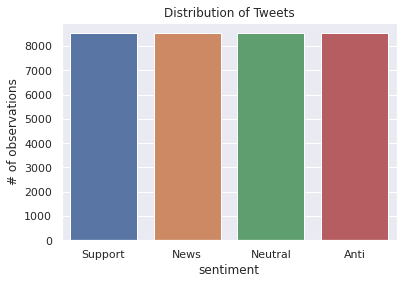

In [99]:
#Distribution of tweets
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="sentiment", data=sampled,
                order=train_df['sentiment'].value_counts().index)
ax.set(xticklabels = (['Support', 'News', 'Neutral', 'Anti']))
plt.ylabel("# of observations")
plt.title('Distribution of Tweets')
None #don't show the label objects

In [100]:
#Bag of Words
vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=10000, stop_words='english')
sampled_bow = vectorizer.fit_transform(sampled['message'])
sampled_bow.shape

(34120, 10000)

In [108]:
#TF-IDF
tv = TfidfVectorizer(min_df=2, max_df=0.90, max_features=10000, stop_words='english', ngram_range=(1,2))
tv.fit(sampled['clean_message'])

tv_train_transformed = tv.transform(sampled['clean_message'])
tv_cv = tv_train_transformed.toarray()

In [103]:
#Logistic Regression on Sampled Data

# Extracting train and test BoW features 
sampled_train = sampled_bow[:15819,:] 
sampled_test = sampled_bow[15819:,:]

# splitting data into training and validation set 
X_train, X_test, y_train, y_test = train_test_split(sampled_train, train['sentiment'], random_state=42, test_size=0.2)

lreg = LogisticRegression(solver='lbfgs') 

# training the model 
lreg.fit(X_train, y_train) 

LogisticRegression()

In [107]:
pred_y = lreg.predict(X_test) #Prediction of Test set
pred_y_train = lreg.predict(X_train) #Prediction of Train set
#Metrics
print('Train Accuracy', accuracy_score(y_train, pred_y_train))
print('Test Accuracy', accuracy_score(y_test, pred_y))
print('Classification Report')
print(classification_report(y_test, pred_y, target_names=['Anti', 'Neutral', 'Support', 'News']))

Train Accuracy 0.6318451205057289
Test Accuracy 0.46017699115044247
Classification Report
              precision    recall  f1-score   support

        Anti       0.10      0.03      0.04       278
     Neutral       0.13      0.06      0.09       425
     Support       0.55      0.75      0.64      1755
        News       0.20      0.14      0.16       706

    accuracy                           0.46      3164
   macro avg       0.25      0.25      0.23      3164
weighted avg       0.38      0.46      0.41      3164



In [111]:
#TF-IDF Sampled Data
sampled_train = tv_cv[:15819,:] 
sampled_test = tv_cv[15819:,:]

X_train, X_test, y_train, y_test = train_test_split(sampled_train, train['sentiment'], random_state=53, test_size=0.33)

td_lreg = LogisticRegression(solver='lbfgs') 

# training the model 
td_lreg.fit(X_train, y_train) 

LogisticRegression()

In [112]:
pred_y = td_lreg.predict(X_test) #Prediction of Test set
pred_y_train = td_lreg.predict(X_train) #Prediction of Train set
#Metrics
print('Train Accuracy', accuracy_score(y_train, pred_y_train))
print('Test Accuracy', accuracy_score(y_test, pred_y))
print('Classification Report')
print(classification_report(y_test, pred_y, target_names=['Anti', 'Neutral', 'Support', 'News']))

Train Accuracy 0.5837893942253255
Test Accuracy 0.5154185022026432
Classification Report
              precision    recall  f1-score   support

        Anti       0.00      0.00      0.00       434
     Neutral       0.17      0.01      0.02       782
     Support       0.54      0.92      0.68      2817
        News       0.23      0.07      0.10      1188

    accuracy                           0.52      5221
   macro avg       0.24      0.25      0.20      5221
weighted avg       0.37      0.52      0.39      5221



<a id="one"></a>
## 6.0 Feature Extraction
<a href=#cont>Back to Table of Contents</a>

---
    
 Description:



###1. Bag-of-Words Features

In [69]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=10000, stop_words='english')
bow = bow_vectorizer.fit_transform(combi['message'])
bow.shape

(26365, 10000)

###2. TF-IDF Features

In [70]:
tv = TfidfVectorizer(min_df=2, max_df=0.90, max_features=10000, stop_words='english', ngram_range=(1,2))
tv.fit(combi['clean_message'])

TfidfVectorizer(max_df=0.9, max_features=10000, min_df=2, ngram_range=(1, 2),
                stop_words='english')

In [72]:
tv_train_transformed = tv.transform(combi['clean_message'])
tv_cv = tv_train_transformed.toarray()

In [73]:
train_tv_df = pd.DataFrame(tv_train_transformed.toarray(),
                     columns=tv.get_feature_names())\
                     .add_prefix('TFIDF_')

In [74]:
examine_row = train_tv_df.iloc[0]


In [75]:
print(examine_row.sort_values(ascending=False))

TFIDF_warming wait        0.319066
TFIDF_think carbon        0.311938
TFIDF_chief think         0.306004
TFIDF_dioxide main        0.300921
TFIDF_main cause          0.275135
                            ...   
TFIDF_people saying       0.000000
TFIDF_people say          0.000000
TFIDF_people predicted    0.000000
TFIDF_people like         0.000000
TFIDF_ab                  0.000000
Name: 0, Length: 10000, dtype: float64


In [76]:
out = train_tv_df.sum()

In [77]:
print(out.sort_values(ascending=False))

TFIDF_climate               1333.271176
TFIDF_change                1314.486416
TFIDF_climate change        1299.673270
TFIDF_global                 829.906121
TFIDF_warming                795.290208
                               ...     
TFIDF_kengarex                 1.112557
TFIDF_kengarex sculpture       1.112557
TFIDF_hey hit                  1.060760
TFIDF_hit good                 1.060760
TFIDF_news judge               1.060760
Length: 10000, dtype: float64


###3. Word2Vec Embedding

In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
import gensim

In [79]:
%%time
tokenized_text = combi['message'].apply(lambda x: x.split()) # tokenizing 

model_w2v = gensim.models.Word2Vec(
            tokenized_text,
            size=200, # desired no. of features/independent variables
            window=5, # context window size
            min_count=2, # Ignores all words with total frequency lower than 2.                                  
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 32, # no.of cores
            seed = 34
) 

model_w2v.train(tokenized_text, total_examples= len(combi['message']), epochs=20)


CPU times: user 2min 36s, sys: 597 ms, total: 2min 37s
Wall time: 1min 23s


In [80]:
model_w2v.wv.most_similar(positive="food")

[('production.', 0.6185816526412964),
 ('breakÃ¢â‚¬Â¦', 0.6063745617866516),
 ('Irresponsible', 0.6025428771972656),
 ('#GAID2017', 0.5933519601821899),
 ('supplies', 0.5874293446540833),
 ('#SDGs…', 0.5718438029289246),
 ('supply', 0.5641403198242188),
 ('@Food_Tank:', 0.5589770078659058),
 ('keynote', 0.5564737319946289),
 ('elitists', 0.5553178787231445)]

In [81]:
model_w2v.most_similar(positive="trump")

[('donald', 0.5341347455978394),
 ('trump,', 0.5078026056289673),
 ('elected?', 0.4924437999725342),
 ('America:', 0.48584628105163574),
 ('Huh?', 0.4828912615776062),
 ('trump...', 0.4787924885749817),
 ('Lmfao', 0.47614437341690063),
 ('@sydneythememe:', 0.47600579261779785),
 ('thing,', 0.4741252064704895),
 ('Yo', 0.4712967276573181)]

In [82]:
# model_w2v['heat']

In [83]:
len(model_w2v['heat']) #The length of the vector is 200

200

###Preparing Vectors for text

In [84]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

In [85]:
wordvec_arrays = np.zeros((len(tokenized_text), 200)) 
for i in range(len(tokenized_text)):
    wordvec_arrays[i,:] = word_vector(tokenized_text[i], 200)
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(26365, 200)

###4. Doc2Vec Embedding

####To implement doc2vec, we have to labelise or tag each tokenised tweet with unique IDs. We can do so by using Gensim’s LabeledSentence() function.

In [86]:
def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(LabeledSentence(s, ["tweet_" + str(i)]))
    return output

labeled_text = add_label(tokenized_text) # label all the tweets

In [87]:
labeled_text[:6]

[LabeledSentence(words=['PolySciMajor', 'EPA', 'chief', "doesn't", 'think', 'carbon', 'dioxide', 'is', 'main', 'cause', 'of', 'global', 'warming', 'and..', 'wait,', 'what!?', 'https://t.co/yeLvcEFXkC', 'via', '@mashable'], tags=['tweet_0']),
 LabeledSentence(words=["It's", 'not', 'like', 'we', 'lack', 'evidence', 'of', 'anthropogenic', 'global', 'warming'], tags=['tweet_1']),
 LabeledSentence(words=['RT', '@RawStory:', 'Researchers', 'say', 'we', 'have', 'three', 'years', 'to', 'act', 'on', 'climate', 'change', 'before', 'it’s', 'too', 'late', 'https://t.co/WdT0KdUr2f', 'https://t.co/Z0ANPT…'], tags=['tweet_2']),
 LabeledSentence(words=['#TodayinMaker#', 'WIRED', ':', '2016', 'was', 'a', 'pivotal', 'year', 'in', 'the', 'war', 'on', 'climate', 'change', 'https://t.co/44wOTxTLcD'], tags=['tweet_3']),
 LabeledSentence(words=['RT', '@SoyNovioDeTodas:', "It's", '2016,', 'and', 'a', 'racist,', 'sexist,', 'climate', 'change', 'denying', 'bigot', 'is', 'leading', 'in', 'the', 'polls.', '#Elect

##Now let’s train a doc2vec model.

In [88]:
%%time 
model_d2v = gensim.models.Doc2Vec(dm=1, # dm = 1 for ‘distributed memory’ model
                                  dm_mean=1, # dm_mean = 1 for using mean of the context word vectors
                                  vector_size=200, # no. of desired features
                                  window=5, # width of the context window                                  
                                  negative=7, # if > 0 then negative sampling will be used
                                  min_count=5, # Ignores all words with total frequency lower than 5.                                  
                                  workers=32, # no. of cores                                  
                                  alpha=0.1, # learning rate                                  
                                  seed = 23, # for reproducibility
                                 ) 

model_d2v.build_vocab([i for i in tqdm(labeled_text)])

model_d2v.train(labeled_text, total_examples= len(train['message']), epochs=15)

100%|██████████| 26365/26365 [00:00<00:00, 2032697.79it/s]


CPU times: user 1min 17s, sys: 20.3 s, total: 1min 37s
Wall time: 1min 10s


####Preparing doc2vec Feature Set

In [89]:
docvec_arrays = np.zeros((len(tokenized_text), 200)) 
for i in range(len(combi)):
    docvec_arrays[i,:] = model_d2v.docvecs[i].reshape((1, 200))    

docvec_df = pd.DataFrame(docvec_arrays) 
docvec_df.shape

(26365, 200)

In [90]:
docvec_df.shape,  wordvec_df.shape

((26365, 200), (26365, 200))

In [91]:
train.shape, test.shape

((15819, 3), (10546, 2))

In [92]:
# Extracting train and test BoW features 
train_bow = bow[:15819,:] 
test_bow = bow[15819:,:]

In [93]:
#Encoding
# le = LabelEncoder()
# Transforming categorical variable to label encoded form
# train['lang_id'] = le.fit_transform(train['lang_id'])
# data['lang_id'] = le.inverse_transform(data['lang_id'])
# data['lang_id'] 

 <a id="one"></a>
## 7.0 Modeling
<a href=#cont>Back to Table of Contents</a>

---
    
 Description: Done with all the pre-modeling stages required to get the data in the proper form and shape. We will be building models on the datasets with different feature sets prepared in the earlier sections — Bag-of-Words, TF-IDF, word2vec vectors, and doc2vec vectors. We will use the following algorithms to build models:


1.   Logistic Regression
2.   Support Vector Machine
3.   RandomForest
4.   XGBoost
5.   Multinomial Naive Bayes Classifier

## 1.0 Logistic Regression

###Bag-of-Words Features







In [121]:
# Extracting train and test BoW features 
train_bow = bow[:15819,:] 
test_bow = bow[15819:,:]

# splitting data into training and validation set 
X_train, X_test, y_train, y_test = train_test_split(train_bow, train['sentiment'], random_state=42, test_size=0.2)

lreg = LogisticRegression(solver='lbfgs') 

# training the model 
lreg.fit(X_train, y_train) 

LogisticRegression()

In [122]:
y_pred = lreg.predict(X_test) #Prediction of Test set
pred_y_train = lreg.predict(X_train) #Prediction of Train set
#Metrics
print('Train Accuracy', accuracy_score(y_train, pred_y_train))
print('Test Accuracy', accuracy_score(y_test, y_pred))
print('Classification Report', classification_report(y_test, y_pred, target_names=['Anti', 'Neutral', 'Support', 'News']))

Train Accuracy 0.9398656657447649
Test Accuracy 0.7487357774968394
Classification Report               precision    recall  f1-score   support

        Anti       0.73      0.44      0.55       278
     Neutral       0.53      0.52      0.52       425
     Support       0.79      0.85      0.82      1755
        News       0.78      0.77      0.77       706

    accuracy                           0.75      3164
   macro avg       0.71      0.64      0.67      3164
weighted avg       0.75      0.75      0.74      3164



In [141]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
cf_matrix

array([[ 123,   50,   90,   15],
       [  16,  219,  171,   19],
       [  26,  125, 1483,  121],
       [   4,   21,  137,  544]])

### TF-ID Features

In [118]:
train_tf = tv_cv[:15819,:] 
test_tf = tv_cv[15819:,:]
# splitting data into training and validation set 
tX_train, tX_test, ty_train, ty_test = train_test_split(train_tf, train['sentiment'], random_state=53, test_size=0.33)

td_lreg = LogisticRegression(solver='lbfgs') 

# training the model 
td_lreg.fit(tX_train, ty_train) 

td_y_pred = td_lreg.predict(tX_test) # predicting

In [119]:
pred_y = td_lreg.predict(tX_test) #Prediction of Test set
pred_y_train = td_lreg.predict(tX_train) #Prediction of Train set
#Metrics
print('Train Accuracy', accuracy_score(ty_train, pred_y_train))
print('Test Accuracy', accuracy_score(ty_test, pred_y))
print('Classification Report', classification_report(ty_test, pred_y))

Train Accuracy 0.5837893942253255
Test Accuracy 0.5154185022026432
Classification Report               precision    recall  f1-score   support

          -1       0.00      0.00      0.00       434
           0       0.17      0.01      0.02       782
           1       0.54      0.92      0.68      2817
           2       0.23      0.07      0.10      1188

    accuracy                           0.52      5221
   macro avg       0.24      0.25      0.20      5221
weighted avg       0.37      0.52      0.39      5221



###Word2Vec Features

In [ ]:
# Extracting train and test Word2Vec features 
train_w2v = wordvec_df.iloc[:15819,:]
test_w2v = wordvec_df.iloc[15819:,:]

# splitting data into training and validation set 
wX_train, wX_test, wy_train, wy_test = train_test_split(train_w2v, train['sentiment'], random_state=42, test_size=0.2)

w_lreg = LogisticRegression(solver='lbfgs') 

# training the model 
w_lreg.fit(wX_train, wy_train) 

LogisticRegression()

In [ ]:
pred_y = w_lreg.predict(wX_test) #Prediction of Test set
pred_y_train = w_lreg.predict(wX_train) #Prediction of Train set
#Metrics
print('Train Accuracy', accuracy_score(wy_train, pred_y_train))
print('Test Accuracy', accuracy_score(wy_test, pred_y))
print('Classification Report', classification_report(wy_test, pred_y))

Train Accuracy 0.7167917819043856
Test Accuracy 0.7079646017699115
Classification Report               precision    recall  f1-score   support

          -1       0.50      0.22      0.31       278
           0       0.54      0.38      0.45       425
           1       0.73      0.85      0.79      1755
           2       0.74      0.75      0.74       706

    accuracy                           0.71      3164
   macro avg       0.63      0.55      0.57      3164
weighted avg       0.69      0.71      0.69      3164



###Doc2Vec Features

In [ ]:
# Extracting train and test Doc2Vec features 
train_d2v = docvec_df.iloc[:15819,:]
test_d2v = docvec_df.iloc[15819:,:]

# splitting data into training and validation set 
dX_train, dX_test, dy_train, dy_test = train_test_split(train_d2v, train['sentiment'], random_state=42, test_size=0.3)

d_lreg = LogisticRegression(solver='lbfgs') 

# training the model 
d_lreg.fit(dX_train, dy_train) 

# predicting
d_y_pred = d_lreg.predict(dX_test) 

In [ ]:
pred_y = d_lreg.predict(dX_test) #Prediction of Test set
pred_y_train = d_lreg.predict(dX_train) #Prediction of Train set
#Metrics
print('Train Accuracy', accuracy_score(dy_train, pred_y_train))
print('Test Accuracy', accuracy_score(dy_test, pred_y))
print('Classification Report', classification_report(dy_test, pred_y))

Train Accuracy 0.6165447484873114
Test Accuracy 0.6002949852507374
Classification Report               precision    recall  f1-score   support

          -1       0.45      0.12      0.20       401
           0       0.40      0.19      0.26       666
           1       0.63      0.83      0.72      2598
           2       0.58      0.46      0.51      1081

    accuracy                           0.60      4746
   macro avg       0.52      0.40      0.42      4746
weighted avg       0.57      0.60      0.56      4746



In [ ]:
#Tuning Logist Reg with TF-IDF
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)

logreg_cv.fit(tX_train ,ty_train) #Fit Data

log_pred = logreg_cv.predict(tX_test)
#Metrics
# print(confusion_matrix(y_test, y_pred))
print(accuracy_score(ty_test, log_pred))
print(classification_report(ty_test, log_pred))
# pd.crosstab(y_test,y_pred)

0.7258744205646861
              precision    recall  f1-score   support

          -1       0.86      0.30      0.45       401
           0       0.65      0.35      0.46       666
           1       0.72      0.91      0.80      2598
           2       0.77      0.66      0.71      1081

    accuracy                           0.73      4746
   macro avg       0.75      0.56      0.61      4746
weighted avg       0.73      0.73      0.70      4746



#2. Support Vector Machine (SVM)


###Bag-of-Words Features

In [ ]:
svc = svm.SVC(kernel='linear', C=1, probability=True)
svc.fit(X_train, y_train) 
svc_y_pred = svc.predict(X_test) # predicting

In [ ]:
#Metrics
print(accuracy_score(y_test, svc_y_pred))
print(classification_report(y_test, svc_y_pred))

0.6858407079646017
              precision    recall  f1-score   support

          -1       0.53      0.47      0.50       401
           0       0.45      0.51      0.48       666
           1       0.76      0.77      0.77      2598
           2       0.71      0.67      0.69      1081

    accuracy                           0.69      4746
   macro avg       0.61      0.60      0.61      4746
weighted avg       0.69      0.69      0.69      4746



###TF-IDF Features

In [ ]:
# training the model
t_svc = svm.SVC(kernel='linear', C=1, probability=True)
t_svc.fit(tX_train, ty_train)  
tsvc_y_pred = t_svc.predict(tX_test)

In [ ]:
#Metrics
print(accuracy_score(ty_test, svc_y_pred))
print(classification_report(ty_test, svc_y_pred))

0.6858407079646017
              precision    recall  f1-score   support

          -1       0.53      0.47      0.50       401
           0       0.45      0.51      0.48       666
           1       0.76      0.77      0.77      2598
           2       0.71      0.67      0.69      1081

    accuracy                           0.69      4746
   macro avg       0.61      0.60      0.61      4746
weighted avg       0.69      0.69      0.69      4746



###Word2Vec Features



In [ ]:
s_w_svc = svm.SVC(kernel='linear', C=1, probability=True) 

# training the model 
s_w_svc.fit(wX_train, wy_train)
s_y_pred = s_w_svc.predict(wX_test) # predicting

#Metrics
print(accuracy_score(wy_test, s_y_pred))
print(classification_report(wy_test, s_y_pred))

0.5474083438685209
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       401
           0       0.00      0.00      0.00       666
           1       0.55      1.00      0.71      2598
           2       0.00      0.00      0.00      1081

    accuracy                           0.55      4746
   macro avg       0.14      0.25      0.18      4746
weighted avg       0.30      0.55      0.39      4746



###Doc2Vec Features

In [ ]:
doc_svc = svm.SVC(kernel='linear', C=1, probability=True) 

# training the model 
doc_svc.fit(dX_train, dy_train)
doc_pred = doc_svc.predict(dX_test) # predicting

#Metrics
print(accuracy_score(dy_test, doc_pred))
print(classification_report(dy_test, doc_pred))

0.5474083438685209
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       401
           0       0.00      0.00      0.00       666
           1       0.55      1.00      0.71      2598
           2       0.00      0.00      0.00      1081

    accuracy                           0.55      4746
   macro avg       0.14      0.25      0.18      4746
weighted avg       0.30      0.55      0.39      4746



#3.0 RandomForest

###Bag of Words

In [ ]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(X_train, y_train) 
prediction = rf.predict(X_test)

In [ ]:
#Metrics
print(accuracy_score(y_test, prediction))
print(classification_report(y_test, prediction))

0.5745891276864729
              precision    recall  f1-score   support

          -1       0.43      0.02      0.05       401
           0       0.39      0.11      0.17       666
           1       0.60      0.85      0.70      2598
           2       0.50      0.42      0.46      1081

    accuracy                           0.57      4746
   macro avg       0.48      0.35      0.34      4746
weighted avg       0.54      0.57      0.52      4746



###TF-IDF Features

In [ ]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(tX_train, ty_train) 
prediction = rf.predict(tX_test)

In [ ]:
#Metrics
print(accuracy_score(ty_test, prediction))
print(classification_report(ty_test, prediction))

0.6820480404551201
              precision    recall  f1-score   support

          -1       0.73      0.27      0.40       401
           0       0.50      0.36      0.42       666
           1       0.71      0.85      0.77      2598
           2       0.68      0.63      0.66      1081

    accuracy                           0.68      4746
   macro avg       0.65      0.53      0.56      4746
weighted avg       0.67      0.68      0.66      4746



###Word2Vec Features

In [ ]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(wX_train, wy_train) 
prediction = rf.predict(wX_test)

In [ ]:
#Metrics
print(accuracy_score(wy_test, prediction))
print(classification_report(wy_test, prediction))

0.5474083438685209
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       401
           0       0.00      0.00      0.00       666
           1       0.55      1.00      0.71      2598
           2       0.00      0.00      0.00      1081

    accuracy                           0.55      4746
   macro avg       0.14      0.25      0.18      4746
weighted avg       0.30      0.55      0.39      4746



###Doc2Vec Features

In [ ]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(dX_train, dy_train) 
prediction = rf.predict(dX_test)

In [ ]:
#Metrics
print(accuracy_score(dy_test, prediction))
print(classification_report(dy_test, prediction))

0.5745891276864729
              precision    recall  f1-score   support

          -1       0.75      0.01      0.01       401
           0       0.56      0.02      0.04       666
           1       0.58      0.91      0.71      2598
           2       0.53      0.32      0.40      1081

    accuracy                           0.57      4746
   macro avg       0.61      0.32      0.29      4746
weighted avg       0.58      0.57      0.49      4746



#4.XGBoost


###Bag of Words Features

In [ ]:
# training the model 
b_xgb_model = XGBClassifier(max_depth=6, n_estimators=1000)
b_xgb_model.fit(X_train, y_train)


XGBClassifier(max_depth=6, n_estimators=1000, objective='multi:softprob')

In [ ]:
pred_y = b_xgb_model.predict(X_test) #Prediction of Test set
pred_y_train = b_xgb_model.predict(X_train) #Prediction of Train set
#Metrics
print('Train Accuracy', accuracy_score(y_train, pred_y_train))
print('Test Accuracy', accuracy_score(y_test, pred_y))
print('Classification Report', classification_report(y_test, pred_y))

Train Accuracy 0.8644014223627025
Test Accuracy 0.7354614412136536
Classification Report               precision    recall  f1-score   support

          -1       0.71      0.41      0.52       278
           0       0.57      0.41      0.48       425
           1       0.76      0.86      0.80      1755
           2       0.75      0.76      0.75       706

    accuracy                           0.74      3164
   macro avg       0.70      0.61      0.64      3164
weighted avg       0.73      0.74      0.72      3164



###TF-IDF Features



In [ ]:
# training the model 
tf_xgb_model = XGBClassifier(max_depth=100, n_estimators=1000)
tf_xgb_model.fit(tX_train, ty_train)

In [ ]:
pred_y = tf_xgb_model.predict(tX_test) #Prediction of Test set
pred_y_train = tf_xgb_model.predict(tX_train) #Prediction of Train set
#Metrics
print('Train Accuracy', accuracy_score(ty_train, pred_y_train))
print('Test Accuracy', accuracy_score(ty_test, pred_y))
print('Classification Report', classification_report(ty_test, pred_y))

###Word2Vec Features

In [ ]:
# training the model 
xgb = XGBClassifier()
xgb.fit(wX_train, wy_train) 

XGBClassifier(objective='multi:softprob')

In [ ]:
pred_y = xgb.predict(wX_test) #Prediction of Test set
pred_y_train = xgb.predict(wX_train) #Prediction of Train set
#Metrics
print('Train Accuracy', accuracy_score(wy_train, pred_y_train))
print('Test Accuracy', accuracy_score(wy_test, pred_y))
print('Classification Report', classification_report(wy_test, pred_y))

Train Accuracy 0.5353615171868826
Test Accuracy 0.554677623261694
Classification Report               precision    recall  f1-score   support

          -1       0.00      0.00      0.00       278
           0       0.00      0.00      0.00       425
           1       0.55      1.00      0.71      1755
           2       0.00      0.00      0.00       706

    accuracy                           0.55      3164
   macro avg       0.14      0.25      0.18      3164
weighted avg       0.31      0.55      0.40      3164



###Doc2Vec Features

In [ ]:
# # training the model 
# xgb_model = XGBClassifier(max_depth=6, n_estimators=1000)
# xgb_model.fit(dX_train, dy_train)
# prediction = xgb_model.predict(dX_test)

In [ ]:
#Metrics
print(accuracy_score(dy_test, prediction))
print(classification_report(dy_test, prediction))

0.7026970080067425
              precision    recall  f1-score   support

          -1       0.70      0.37      0.49       401
           0       0.58      0.38      0.46       666
           1       0.71      0.87      0.78      2598
           2       0.72      0.63      0.67      1081

    accuracy                           0.70      4746
   macro avg       0.68      0.56      0.60      4746
weighted avg       0.70      0.70      0.69      4746



###Tuning XBBOOST

In [ ]:
colsample_bytree = [0.3, 0.5, 1.0]
gamma = [0.1, 1, 1.5]
learning_rate = [0.001, 0.01]
min_child_weight = [1, 5, 10]
scale_pos_weight = [1, 2, 4]
subsample = [0.8, 0.9, 1.0]
n_estimators = [50, 100, 150]
max_depth = [5, 100]

param_grid = dict(
    colsample_bytree=colsample_bytree,
    gamma=gamma,
    learning_rate=learning_rate,
    min_child_weight=min_child_weight,
    scale_pos_weight=scale_pos_weight,
    subsample=subsample,
    n_estimators=n_estimators,
    max_depth=max_depth,
)

In [ ]:
model = XGBClassifier(random_state=1, verbosity=1)

grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           )
best_model = grid_search.fit(X_train, y_train)
print('Optimum parameters', best_model.best_params_)

In [ ]:
tuned_model = XGBClassifier(random_state=1, 
                            colsample_bytree=0.3, 
                            gamma=1, 
                            learning_rate=0.01, 
                            max_depth=5, 
                            min_child_weight=1,
                            n_estimators=100,
                            scale_pos_weight=2, 
                            subsample=0.9)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(tuned_model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC/AUC = ', scores.mean())

# 5. Multinomial Naive Bayes Classifier

####Bag of Words Features

In [ ]:

#Create MultinomialNB object
clf = MultinomialNB(alpha=0.6)
# Train clf
clf.fit(X_train, y_train)

MultinomialNB(alpha=0.6)

In [ ]:
pred_y = clf.predict(X_test) #Prediction of Test set
pred_y_train = clf.predict(X_train) #Prediction of Train set
#Metrics
print('Train Accuracy', accuracy_score(y_train, pred_y_train))
print('Test Accuracy', accuracy_score(y_test, pred_y))
print('Classification Report', classification_report(y_test, pred_y))

Train Accuracy 0.8456736467799288
Test Accuracy 0.7048040455120101
Classification Report               precision    recall  f1-score   support

          -1       0.56      0.47      0.51       278
           0       0.48      0.46      0.47       425
           1       0.79      0.76      0.78      1755
           2       0.68      0.80      0.73       706

    accuracy                           0.70      3164
   macro avg       0.63      0.62      0.62      3164
weighted avg       0.70      0.70      0.70      3164



###TF-IDF Features

In [ ]:
tf_clf = MultinomialNB(alpha=0.6).fit(tX_train, ty_train)
# Train clf
tf_clf.fit(tX_train, ty_train)

MultinomialNB(alpha=0.6)

In [ ]:
pred_y = tf_clf.predict(tX_test) #Prediction of Test set
pred_y_train = tf_clf.predict(tX_train) #Prediction of Train set
#Metrics
print('Train Accuracy', accuracy_score(ty_train, pred_y_train))
print('Test Accuracy', accuracy_score(ty_test, pred_y))
print('Classification Report', classification_report(ty_test, pred_y))

Train Accuracy 0.7873183619550859
Test Accuracy 0.6925876268914001
Classification Report               precision    recall  f1-score   support

          -1       0.85      0.20      0.33       434
           0       0.64      0.22      0.33       782
           1       0.67      0.92      0.78      2817
           2       0.76      0.64      0.69      1188

    accuracy                           0.69      5221
   macro avg       0.73      0.50      0.53      5221
weighted avg       0.70      0.69      0.65      5221



###Word2Vec Features

In [ ]:
w_clf = MultinomialNB(alpha=0.6).fit(wX_train, wy_train)
# Compute Prediction
prediction = w_clf.predict(wX_test)

In [ ]:
pred_y = w_clf.predict(wX_test) #Prediction of Test set
pred_y_train = w_clf.predict(wX_train) #Prediction of Train set
#Metrics
print('Train Accuracy', accuracy_score(wy_train, pred_y_train))
print('Test Accuracy', accuracy_score(wy_test, pred_y))
print('Classification Report', classification_report(wy_test, pred_y))

Train Accuracy 0.5353615171868826
Test Accuracy 0.554677623261694
Classification Report               precision    recall  f1-score   support

          -1       0.00      0.00      0.00       278
           0       0.00      0.00      0.00       425
           1       0.55      1.00      0.71      1755
           2       0.00      0.00      0.00       706

    accuracy                           0.55      3164
   macro avg       0.14      0.25      0.18      3164
weighted avg       0.31      0.55      0.40      3164



#Predict Test data for submission.


In [ ]:
#To predict the test data for kaggle submission.
# final_pred = xgb.predict(test_w2v)

# final_pred = lreg.predict(test_bow) #BOW Logistic Reg

final_pred = b_xgb_model.predict(test_tf) #BOW XGBOOST

# final_pred = td_lreg.predict(test_tf)#TF-IDF Logistic Reg



#Saving Best Performing Models

In [ ]:
#Save Model XGBOOST With Pickle
import pickle

model_save_path = "xgb_model.pkl" #SVM
with open(model_save_path,'wb') as file:
    pickle.dump(xgb, file)


In [ ]:
#Save Model XGBOOST With Pickle (BOW)
import pickle

model_save_path = "xgb_model.pkl" #SVM
with open(model_save_path,'wb') as file:
    pickle.dump(b_xgb_model, file)

In [ ]:
#Open Model With Pickle
model_load_path = "xgb_model.pkl"
with open(model_load_path,'rb') as file:
    unpickled_model = pickle.load(file)

In [ ]:
# get predictions from unpickled model
xgb_pred = unpickled_model.predict(wX_test)

In [ ]:
#Save Model Logistic Reg With Pickle
import pickle
model_save_path = "log_model.pkl" #SVM
with open(model_save_path,'wb') as file:
    pickle.dump(lreg, file)

 <a id="one"></a>
## 7.0 File Submission
<a href=#cont>Back to Table of Contents</a>

---
    
 Description: Generate and submit CSV file to Kaggle

In [ ]:
sub = pd.read_csv(url_sub)
sub.head()

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,1


In [ ]:
# Create a submisison dataframe and append the relevant columns
submission = pd.DataFrame()
submission['tweetid'] = test['tweetid']
submission['sentiment'] = final_pred # our model predictions on the test dataset
submission.head()

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,1


In [ ]:
# for Kaggle submisison
submission.to_csv('climate_change.csv', index=False)
print('Submission CSV is ready!')

Submission CSV is ready!


In [ ]:
# Check the submission csv to make sure it's in the right format
submissions_check = pd.read_csv("climate_change.csv")
submissions_check.head()

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,1


In [ ]:
submission.shape

(10546, 2)

In [ ]:
from google.colab import files
files.download("climate_change.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>